In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from ipywidgets import interact
plotly.offline.init_notebook_mode(connected=True)

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images

from src.utils.utils import add_spatial_encoding
from src.utils.node import  BatchGetterMultiImages, train_convnode_with_batch, train_convnode_with_batch_and_latent_supervision
from src.utils.viz import  display_convnode_trajectory

from src.models.convnode import ConvNodeWithBatch#, LatentRegularizerLoss


In [37]:
MARGIN_MIN = 5
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 28, 28
RADIUS = 3

infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}

x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)


Num_pos_velocity = 1
N = 1000
N_frames = 300 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)
print("-"*50)
print("Generating images...")
images = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos).reshape(-1, 1, HEIGHT, WIDTH)
print(images.shape)
# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)
print(images.shape)


--------------------------------------------------
Generating images...


100%|██████████| 1000/1000 [00:51<00:00, 19.53it/s]


(301000, 1, 28, 28)
torch.Size([1000, 301, 3, 28, 28])


In [17]:
print("-"*50)
print("Creating model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = 28
latent_dim = 16
in_channels = 3
ode_data_dim = latent_dim
ode_hidden_dim = 128
augment_dim = 0
time_dependent=False
ode_non_linearity='relu' 
conv_activation=nn.ReLU()
latent_activation=None
stack_size=1

conv_ode = ConvNodeWithBatch(device, size, latent_dim, in_channels,
    ode_hidden_dim, ode_data_dim, augment_dim=augment_dim, time_dependent=time_dependent,
    ode_non_linearity=ode_non_linearity, ode_linear_layer=False, conv_activation=conv_activation,
    latent_activation=latent_activation, stack_size=stack_size)

# pathConvODE = "models/AE_ODE/ConvODE/conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
# pathConvODE = "ssh/conv_ode_1_ball_latent_32_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_together.pt"
# pathConvODE = "ssh/conv_ode_1_ball_latent_32_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_ODE_and_decoder.pt"
# # pathConvODE = "conv_ode_1_ball_latent_10_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_together_v2.pt"
# pathConvODE = "conv_ode_1_ball_latent_3_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_ODE_and_decoder_new_loss_sep_and_jointly.pt"
# print(conv_ode.load_state_dict(torch.load(pathConvODE, map_location=device)))

--------------------------------------------------
Creating model...
--------------------------------------------------
Creating ConvAE...
Number of parameters in the encoder model: 127568
Number of parameters in the decoder model: 127715
--------------------------------------------------
Creating ANODENet...
Number of parameters in the model: 25392


In [38]:
print("-"*50)
print("Creating tools to train...")
batch_size = 16
batch_time = 200
n_stack = 1
total_length = N_frames - Num_pos_velocity
getter = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images, frac_train=1.)

--------------------------------------------------
Creating tools to train...


# Loss without latent supervision

In [32]:
from src.models.convnode import TimeDistributed

class LatentRegularizerLoss(nn.Module):
    def __init__(self, device, reg_lambda, step_decay=1, decay_rate=0.9, weighted=False):
        super(LatentRegularizerLoss, self).__init__()
        self.device = device
        self.reg_lambda = reg_lambda
        
        if weighted:
            self.image_loss = nn.MSELoss(reduction="none")
        else:
            self.image_loss = nn.MSELoss()
        
        self.step_decay = step_decay
        self.decay_rate = decay_rate
        self._step = 0
        self.weighted = weighted

    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        # print(loss_img.shape)
        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.0 + 5 * weights)
            # print(weights)
            loss_img = loss_img.mean(dim=(2,3,4))*weights 
        loss_img = loss_img.mean(dim=-1).mean(dim=-1)

        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        # print("loss_img: ", loss_img)
        # print("loss_reg: ", loss_reg)
        return loss_img + self.reg_lambda * loss_reg
    

    def step(self):
        self._step +=1
        if self._step % self.step_decay == 0:
            self.reg_lambda *= self.decay_rate
            

    def forward_print(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)

        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.1 + 2 * weights)
            # print(weights)
            loss_img_weighted = loss_img.mean(dim=(2,3,4))*weights 
            loss_img = loss_img.mean(dim=(2,3,4))

        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", loss_img.mean(dim=-1).mean(dim=-1))
        if self.weighted:
            print("loss_img weighted: ", loss_img_weighted.mean(dim=-1).mean(dim=-1))
        print("loss_reg: ", self.reg_lambda * loss_reg)
        print("reg_lambda: ",self.reg_lambda)
        print("-"*73)
        return None

class FinalStateWeightingMSE(nn.Module):
    def __init__(self):
        super(FinalStateWeightingMSE, self).__init__()
        # self.mse = TimeDistributedLoss(nn.MSELoss(),
        #                     4
        # )

        self.mse = nn.MSELoss(reduction="none")
        
    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.mse(pred_images, true_images).mean(dim=(2,3,4))
        # print(loss_img.shape)
        weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
        # print(weights.shape)
        # print(weights)
        weights = (0.0 + 5 * weights)
        # print(weights)
        loss_img = loss_img*weights
        # print(loss_img)
        return loss_img.mean(dim=-1).mean(dim=-1)

    def step(self):
        pass

    def forward_print(self, latent_z, pred_images, true_images):
        loss_img = self.mse(pred_images, true_images).mean(dim=(2,3,4))
        # print(loss_img.shape)
        weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
        # print(weights.shape)
        # print(weights)
        weights = (0.1 + 2 * weights)
        # print(weights)
        loss_img_weighted = loss_img*weights
        # print(loss_img)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", loss_img.mean(dim=-1).mean(dim=-1))
        print("loss_img weighted: ", loss_img_weighted.mean(dim=-1).mean(dim=-1))
        print("-"*73)
        return loss_img_weighted.mean(dim=-1).mean(dim=-1), loss_img.mean(dim=-1).mean(dim=-1)


optimizerEnc = torch.optim.Adam(conv_ode.encoder.parameters(), lr=1e-5)
optimizerDec = torch.optim.Adam(conv_ode.decoder.parameters(), lr=1e-5)
optimizerODE = torch.optim.Adam(conv_ode.node.parameters(), lr=1e-4)
optimizers = [optimizerEnc, optimizerDec, optimizerODE]
scheduler = torch.optim.lr_scheduler.StepLR(optimizerODE, step_size=2000, gamma=0.9)

reg_lambda = 1e-2
loss_fn = LatentRegularizerLoss(device, reg_lambda, step_decay=3000, decay_rate=0.8, weighted=True)




In [20]:
# loss_fn = FinalStateWeightingMSE()
inputs = torch.zeros(3, 10, in_channels, size, size).to(device)
outputs = torch.zeros(3, 10, in_channels, size, size).to(device)
latent_z = torch.zeros(1)
loss_fn(latent_z, inputs, outputs)
loss_fn.forward_print(latent_z, inputs, outputs)

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0., device='cuda:0')
loss_img weighted:  tensor(0., device='cuda:0')
loss_reg:  tensor(0.)
reg_lambda:  0.0
-------------------------------------------------------------------------


# Loss with latent supervision

In [92]:
class LatentRegularizerLossWithLatent(nn.Module):
    def __init__(self, device, reg_lambda, latent_lambda, step_decay=1, decay_rate=0.9, weighted=False):
        super(LatentRegularizerLossWithLatent, self).__init__()
        self.device = device
        self.reg_lambda = reg_lambda
        self.latent_lambda = latent_lambda
        
        if weighted:
            self.image_loss = nn.MSELoss(reduction="none")
        else:
            self.image_loss = nn.MSELoss()
        
        self.step_decay = step_decay
        self.decay_rate = decay_rate
        self._step = 0
        self.weighted = weighted

    def forward(self, pred_latent, true_latent, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_latent = self.image_loss(pred_latent, true_latent)
        # print(loss_img.shape)
        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.0 + 5 * weights)
            # print(weights)
            loss_img = loss_img.mean(dim=(2,3,4))*weights 

            loss_latent = loss_latent.mean(dim=-1)*weights

        loss_img = loss_img.mean(dim=-1).mean(dim=-1)

        loss_latent = loss_latent.mean(dim=-1).mean(dim=-1)

        loss_reg = torch.linalg.norm(true_latent, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        # print("loss_img: ", loss_img)
        # print("loss_reg: ", loss_reg)
        return loss_img + self.reg_lambda * loss_reg + self.latent_lambda*loss_latent
    

    def step(self):
        self._step +=1
        if self._step % self.step_decay == 0:
            self.reg_lambda *= self.decay_rate
            

    def forward_print(self, pred_latent, true_latent, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_latent = self.image_loss(pred_latent, true_latent)

        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.1 + 2 * weights)
            # print(weights)
            loss_img_weighted = loss_img.mean(dim=(2,3,4))*weights 
            loss_img = loss_img.mean(dim=(2,3,4))

            loss_latent_weighted = loss_latent.mean(dim=-1)*weights
            loss_latent = loss_latent.mean(dim=-1)
        


        

        loss_reg = torch.linalg.norm(true_latent, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", "{:.6f}".format(loss_img.mean(dim=-1).mean(dim=-1).item()))
        if self.weighted:
            print("loss_img weighted: ", "{:.6f}".format((loss_img_weighted.mean(dim=-1).mean(dim=-1)).item()))

        print("loss_latent unweighted: ", "{:.6f}".format((self.latent_lambda*loss_latent.mean(dim=-1).mean(dim=-1)).item()))
        if self.weighted:
            print("loss_latent weighted: ", "{:.6f}".format((self.latent_lambda*loss_latent_weighted.mean(dim=-1).mean(dim=-1)).item()))
        print("loss_reg: ", "{:.6f}".format((self.reg_lambda * loss_reg).item()))
        print("reg_lambda: ","{:.6f}".format((self.reg_lambda)))
        print("-"*73)
        return None

reg_lambda = 0 #5e-3
latent_lambda = 5
loss_fn = LatentRegularizerLossWithLatent(device, reg_lambda, latent_lambda, step_decay=3000, decay_rate=0.8, weighted=False)

In [86]:
# loss_fn = FinalStateWeightingMSE()
inputs = torch.randn(3, 10, in_channels, size, size).to(device)
outputs = torch.randn(3, 10, in_channels, size, size).to(device)
pred_latent = torch.randn(3, 10, 2).to(device)
true_latent = torch.randn(3, 10, 2).to(device)

print(loss_fn(pred_latent, true_latent, inputs, outputs))
loss_fn.forward_print(pred_latent, true_latent, inputs, outputs)

tensor(14.9898, device='cuda:0')
------------------------------ Loss prints ------------------------------
loss_img unweighted:  2.011830
loss_latent unweighted:  12.977978
loss_reg:  0.000000
reg_lambda:  0.000000
-------------------------------------------------------------------------


# Training process

In [22]:
root = None #"images/AE_ODE/Gravity/MultiTrajectories/Together/"
name = None # "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
display_fn = lambda i, model, out_display, getter, final_time, dt: display_convnode_trajectory(i, model, out_display, getter, final_time, dt, root=root, name=name)
# display_fn(0, conv_ode, latent_dim, getter, N_frames - Num_pos_velocity, dt)

## Training with latent supervision

In [94]:
optimizer = torch.optim.Adam(conv_ode.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

--------------------------------------------------
Training...


  1%|          | 499/50000 [01:10<1:59:34,  6.90it/s, Loss: 0.01213414]

The graphs at epoch 500


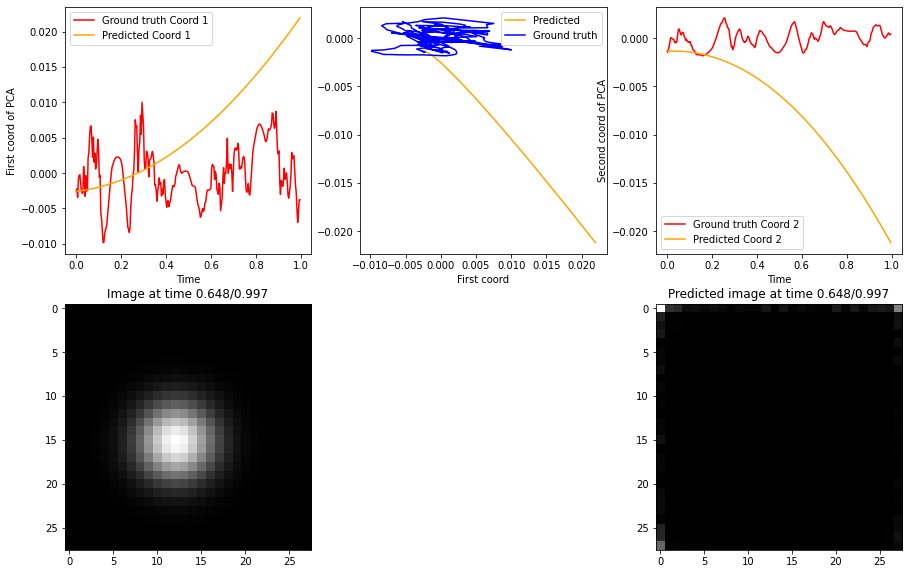

Display loss: 0.03165094:   1%|          | 501/50000 [01:11<3:25:13,  4.02it/s, Loss: 0.01109493]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  0.012119
loss_latent unweighted:  0.000015
loss_reg:  0.000000
reg_lambda:  0.000000
-------------------------------------------------------------------------


Display loss: 0.03165094:   2%|▏         | 999/50000 [02:22<1:56:09,  7.03it/s, Loss: 0.01155081]

The graphs at epoch 1000


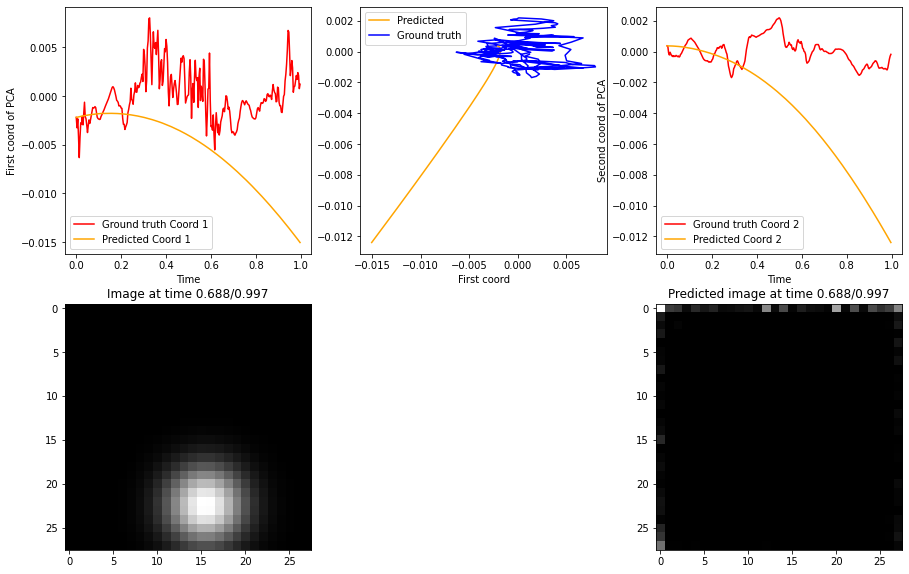

Display loss: 0.01127540:   2%|▏         | 1001/50000 [02:23<3:20:13,  4.08it/s, Loss: 0.01143022]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  0.011544
loss_latent unweighted:  0.000007
loss_reg:  0.000000
reg_lambda:  0.000000
-------------------------------------------------------------------------


Display loss: 0.01127540:   2%|▏         | 1141/50000 [02:43<1:56:41,  6.98it/s, Loss: 0.01146191]


KeyboardInterrupt: 

In [95]:
print("-"*50)
print("Training...")
epochs = 50000

# for param in conv_ode.node.parameters():
#     param.requires_grad = True
    
train_convnode_with_batch_and_latent_supervision(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=500, display_results_fn=display_fn)

## Training without latent supervision

--------------------------------------------------
Training...


  1%|          | 499/50000 [01:23<2:17:24,  6.00it/s, Loss: 0.00355872]

The graphs at epoch 500


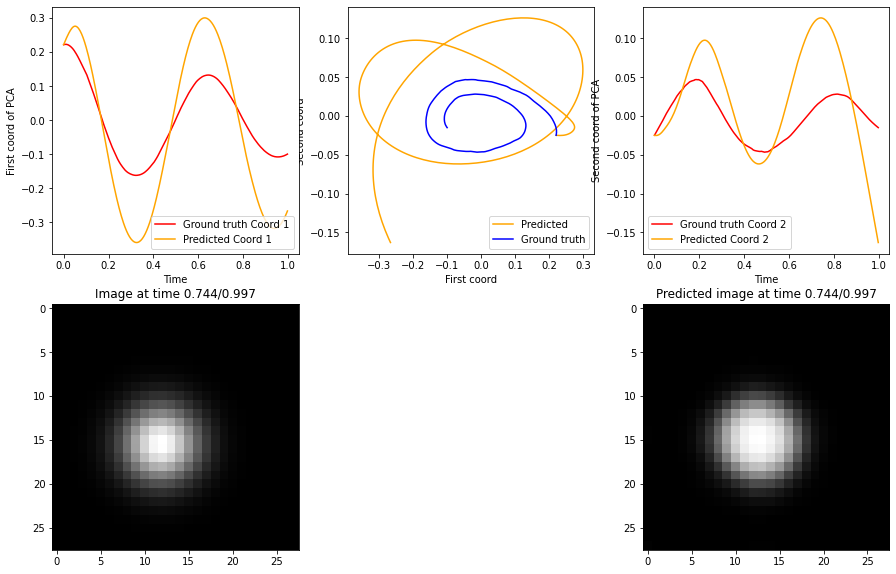

Display loss: 0.00150252:   1%|          | 501/50000 [01:24<3:59:28,  3.45it/s, Loss: 0.00141815]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.8396e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  7.378697629483831e-05
-------------------------------------------------------------------------


Display loss: 0.00150252:   2%|▏         | 999/50000 [02:46<2:17:07,  5.96it/s, Loss: 0.00136265]

The graphs at epoch 1000


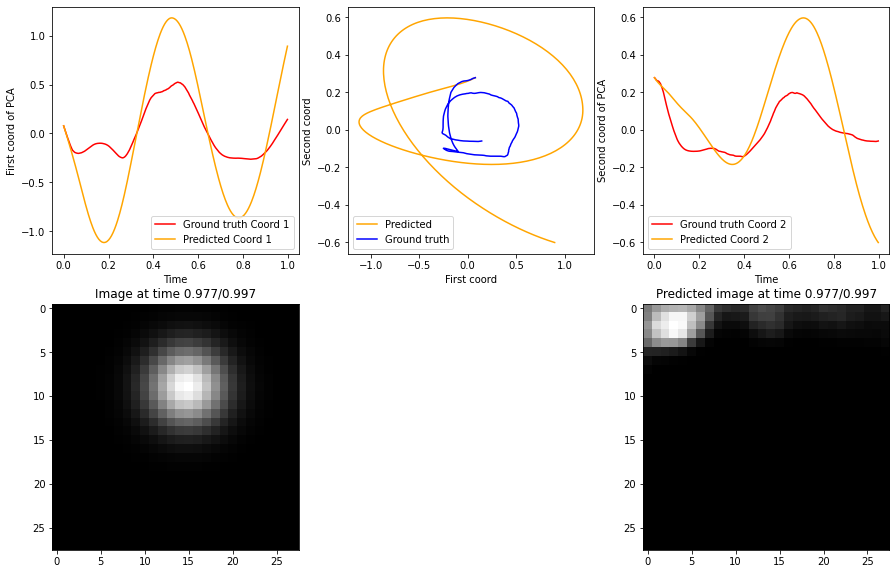

Display loss: 0.00142583:   2%|▏         | 1001/50000 [02:47<3:43:43,  3.65it/s, Loss: 0.00140988]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(2.7587e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  5.902958103587065e-05
-------------------------------------------------------------------------


Display loss: 0.00142583:   3%|▎         | 1499/50000 [04:10<2:13:52,  6.04it/s, Loss: 0.00228354]

The graphs at epoch 1500


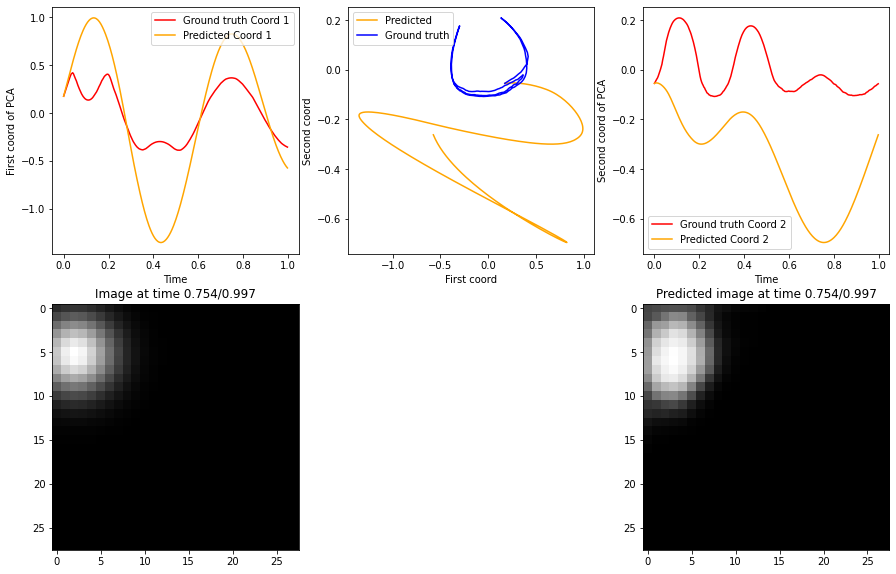

Display loss: 0.00136833:   3%|▎         | 1501/50000 [04:11<3:41:12,  3.65it/s, Loss: 0.00145531]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.1631e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  5.902958103587065e-05
-------------------------------------------------------------------------


Display loss: 0.00136833:   4%|▍         | 1999/50000 [05:34<2:13:07,  6.01it/s, Loss: 0.00081653]

The graphs at epoch 2000


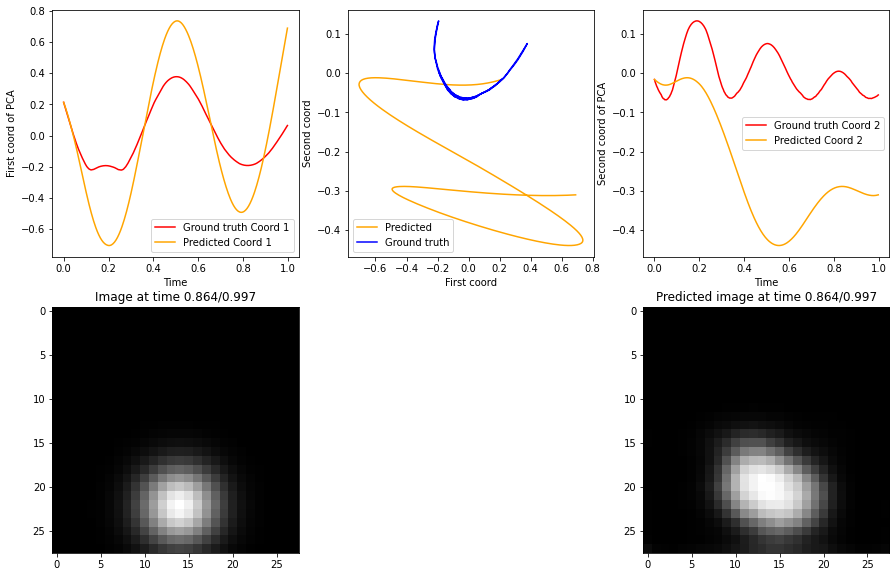

Display loss: 0.00136600:   4%|▍         | 2001/50000 [05:35<3:38:52,  3.66it/s, Loss: 0.00095074]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(2.9906e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  5.902958103587065e-05
-------------------------------------------------------------------------


Display loss: 0.00136600:   5%|▍         | 2499/50000 [06:57<2:13:00,  5.95it/s, Loss: 0.00094740]

The graphs at epoch 2500


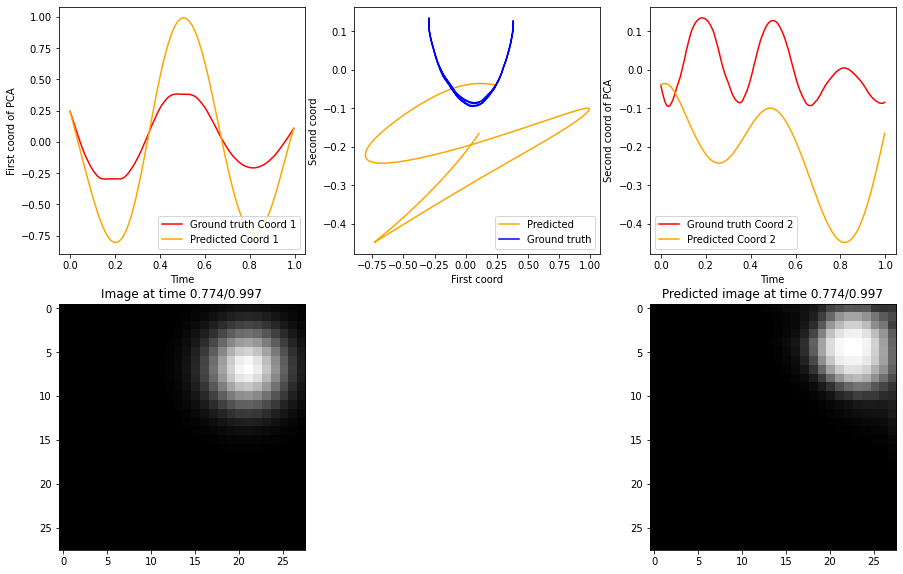

Display loss: 0.00137246:   5%|▌         | 2501/50000 [06:58<3:56:23,  3.35it/s, Loss: 0.00108559]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.2270e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  5.902958103587065e-05
-------------------------------------------------------------------------


Display loss: 0.00137246:   6%|▌         | 2999/50000 [08:21<2:09:54,  6.03it/s, Loss: 0.00110912]

The graphs at epoch 3000


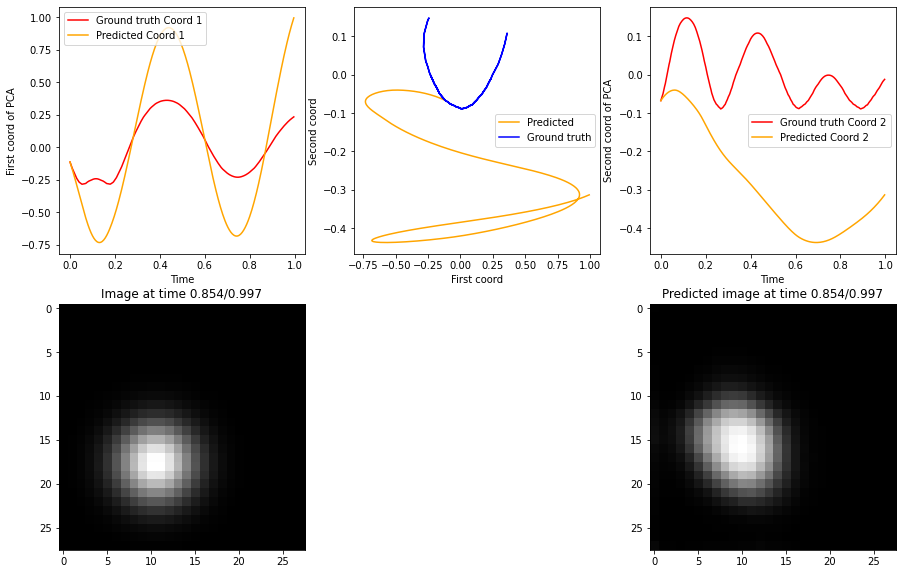

Display loss: 0.00133568:   6%|▌         | 3001/50000 [08:22<3:51:25,  3.38it/s, Loss: 0.00108273]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.1741e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  5.902958103587065e-05
-------------------------------------------------------------------------


Display loss: 0.00133568:   7%|▋         | 3499/50000 [09:45<2:10:31,  5.94it/s, Loss: 0.00138157]

The graphs at epoch 3500


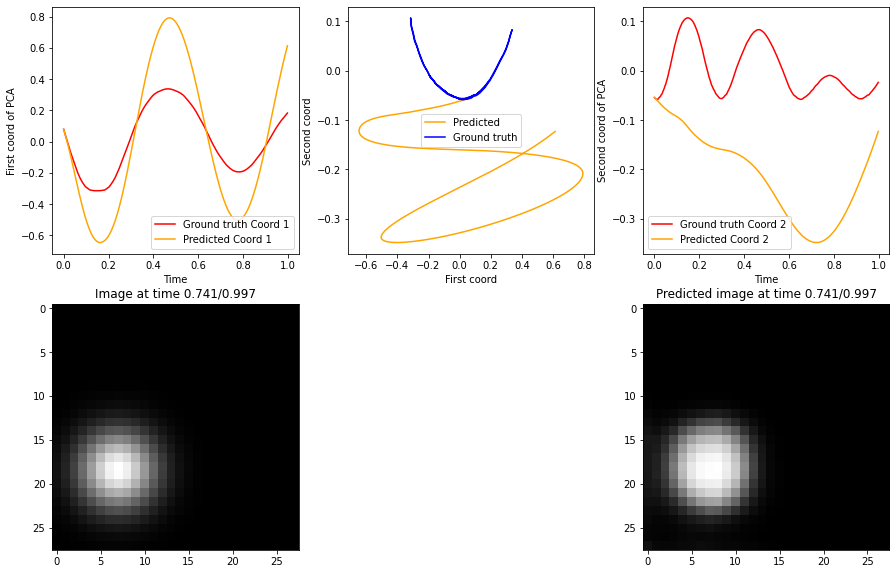

Display loss: 0.00132546:   7%|▋         | 3501/50000 [09:45<3:34:20,  3.62it/s, Loss: 0.00086839]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(2.7536e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  5.902958103587065e-05
-------------------------------------------------------------------------


Display loss: 0.00132546:   8%|▊         | 3999/50000 [11:08<2:07:00,  6.04it/s, Loss: 0.00168317]

The graphs at epoch 4000


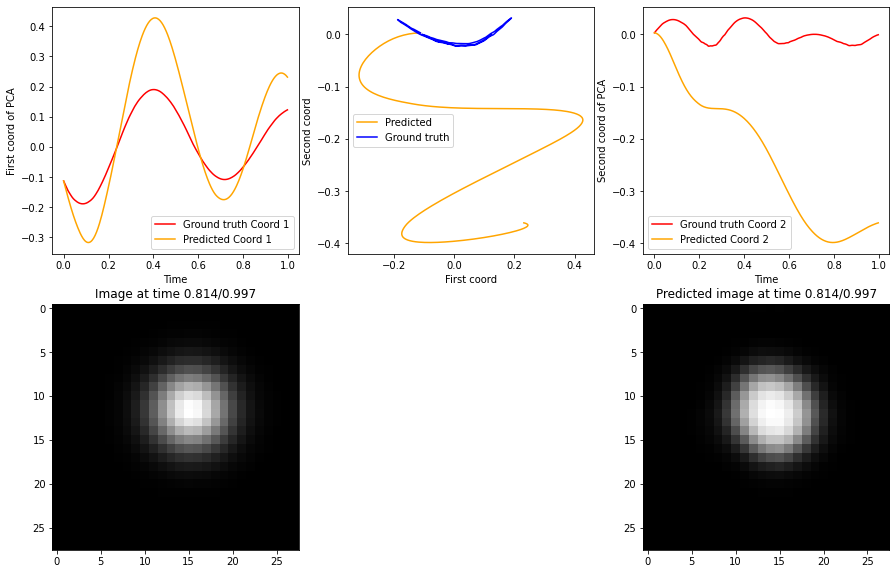

Display loss: 0.00130903:   8%|▊         | 4001/50000 [11:09<3:26:04,  3.72it/s, Loss: 0.00078347]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(2.7134e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  4.722366482869652e-05
-------------------------------------------------------------------------


Display loss: 0.00130903:   9%|▉         | 4499/50000 [12:32<2:05:15,  6.05it/s, Loss: 0.00118093]

The graphs at epoch 4500


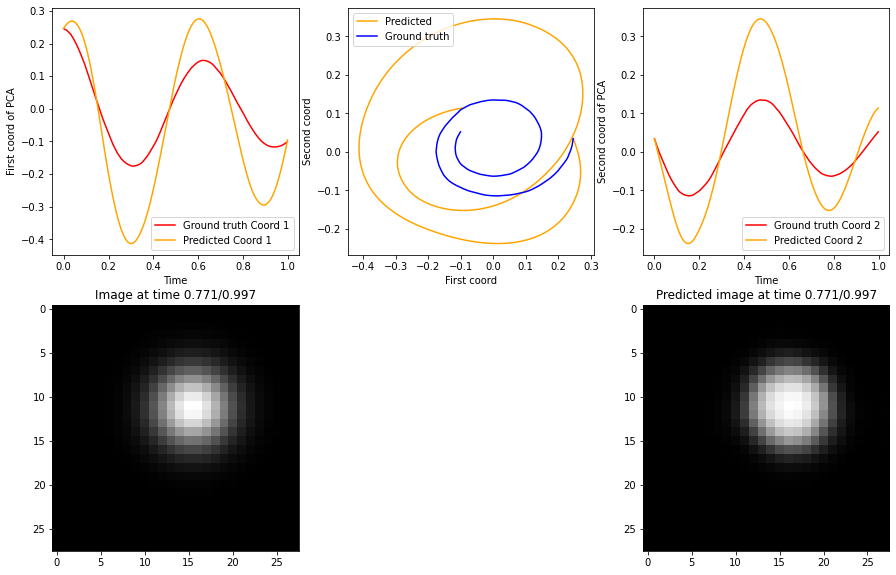

Display loss: 0.00129402:   9%|▉         | 4501/50000 [12:33<3:30:52,  3.60it/s, Loss: 0.00118806]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(2.8416e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  4.722366482869652e-05
-------------------------------------------------------------------------


Display loss: 0.00129402:  10%|▉         | 4999/50000 [13:56<2:06:09,  5.94it/s, Loss: 0.00174758]

The graphs at epoch 5000


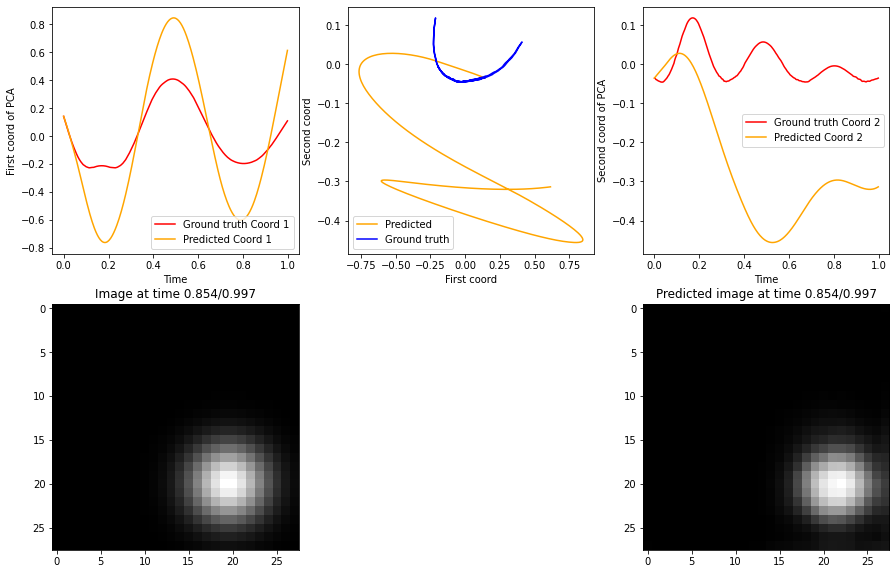

Display loss: 0.00133249:  10%|█         | 5001/50000 [13:56<3:38:14,  3.44it/s, Loss: 0.00121921]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(2.2999e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  4.722366482869652e-05
-------------------------------------------------------------------------


Display loss: 0.00133249:  10%|█         | 5026/50000 [14:01<2:05:26,  5.98it/s, Loss: 0.00206911]


KeyboardInterrupt: 

In [45]:
print("-"*50)
print("Training...")
epochs = 50000

# for param in conv_ode.node.parameters():
#     param.requires_grad = True
    
train_convnode_with_batch(conv_ode, optimizers, scheduler, epochs,
    getter, loss_fn=loss_fn, display=500, display_results_fn=display_fn)

In [46]:
pathConvODE = "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_last_model.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
torch.save(conv_ode.state_dict(), pathConvODE)

In [51]:
# To continue training :
print(loss_fn.reg_lambda)
print(optimizerODE)

4.722366482869652e-05
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 1.667718169966658e-05
    weight_decay: 0
)


--------------------------------------------------
Training...


  3%|▎         | 997/30000 [00:24<11:17, 42.82it/s, Loss: 0.00136569]

The graphs at epoch 1000


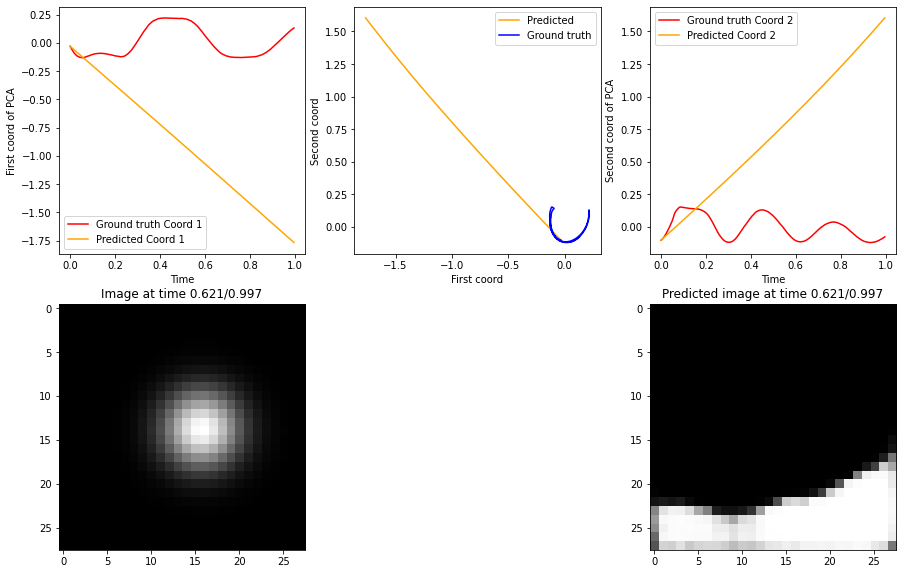

Display loss: 0.00494316:   3%|▎         | 1007/30000 [00:24<22:50, 21.16it/s, Loss: 0.00239880]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0016384000000000004
-------------------------------------------------------------------------


Display loss: 0.00494316:   5%|▍         | 1426/30000 [00:34<11:34, 41.14it/s, Loss: 0.00245312]


KeyboardInterrupt: 

In [9]:
print("-"*50)
print("Training...")
for param in conv_ode.encoder.parameters():
    param.requires_grad = False

for param in conv_ode.decoder.parameters():
    param.requires_grad = False

# loss_fn.reg_lambda = 0.
optimizer = torch.optim.Adam(conv_ode.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

epochs = 30000
train_convnode_with_batch(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=1000, display_results_fn=display_fn)

In [28]:
pathConvODE = "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay_ODE_and_decoder_new_loss_sep_and_jointly.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
torch.save(conv_ode.state_dict(), pathConvODE)

In [52]:
from skimage.color import gray2rgb

def generate_interactive_plot(i, model, out_display, getter, final_time, dt, root=None, name=None):

    index = np.random.randint(0, getter.N_train)
    time_steps = np.linspace(0, final_time*dt, final_time)

    times = torch.arange(0, final_time*dt, dt)

    gd_images = getter.train_images[index, :-1][:,0].cpu().numpy()
    input_images = getter.train_images[index, :2]
    with torch.no_grad():
        reconstructed_images, _ = model(input_images.to(device), times.to(device), dt)
        reconstructed_images = reconstructed_images.cpu().numpy()

    print("Sim", reconstructed_images.shape, gd_images.shape)

    gd_images = np.expand_dims(gd_images, axis=1)
    reconstructed_images = np.expand_dims(reconstructed_images[:,0], axis=1)
    print("Extract Gray", gd_images.shape, reconstructed_images.shape)

    gd_images = np.array([gray2rgb(img[0]) for img in gd_images])
    gd_images = 200*(gd_images - gd_images.min())/(gd_images.max() - gd_images.min())
    print("Gray to rgb for gd_images", gd_images.shape, reconstructed_images.shape)

    reconstructed_images = np.array([gray2rgb(img[0]) for img in reconstructed_images])
    reconstructed_images = 200*(reconstructed_images - reconstructed_images.min())/(reconstructed_images.max() - reconstructed_images.min())

    print("Gray to rgb for reconstructed", gd_images.shape, reconstructed_images.shape)

    return interactive_part_trajectory_image_plot(gd_images, reconstructed_images, time_steps, dt)


def interactive_part_trajectory_image_plot(inputs_images, reconstructed_images, time_steps, dt):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Input image", "Predicted image"))
    fig = go.FigureWidget(fig)
    # add a black background to the figure
    fig.add_image(z=inputs_images[0], row=1, col=1, name='true image')
    fig.add_image(z=reconstructed_images[0], row=1, col=2, name='predicted image')

    N_max_input = len(inputs_images)-1
    N_max_predicted = len(reconstructed_images)-1
    N_max = max(N_max_input, N_max_predicted)

    frac_input = 1. #N_max/N_max_predicted
    frac_predicted = 1. #N_max/N_max_input

    @interact(t=(time_steps.min(),time_steps.max(),dt))
    def update_plot(t):
        with fig.batch_update():
            # change the current point of 
            print(t/dt)
            print(int(frac_input*t/dt))
            print(int(frac_predicted*t/dt))
            fig.data[0].z = inputs_images[min(int(frac_input*t/dt), N_max_input)]
            fig.data[1].z = reconstructed_images[min(int(frac_predicted*t/dt), N_max_predicted)]

    return fig

In [53]:
fig = generate_interactive_plot(0, conv_ode, 0, getter, N_frames - Num_pos_velocity, dt, root=None, name=None)
fig

Sim (300, 3, 28, 28) (300, 28, 28)
Extract Gray (300, 1, 28, 28) (300, 1, 28, 28)
Gray to rgb for gd_images (300, 28, 28, 3) (300, 1, 28, 28)
Gray to rgb for reconstructed (300, 28, 28, 3) (300, 28, 28, 3)


interactive(children=(FloatSlider(value=0.4983388704318937, description='t', max=0.9966777408637874, step=0.00…

FigureWidget({
    'data': [{'name': 'true image',
              'type': 'image',
              'uid': 'a13cc6…